In [1]:
# read dataset one image

# image_size=128, batch_size:256, epochs=10, drop_out=0.25,0.5, score=2.6896452718267965e-05
# image_size=128, batch_size:128, epochs=10, drop_out=0.25,0.5, score=2.0310855384028685e-05
# image_size=128, batch_size:128, epochs=20, drop_out=0.25,0.5, score=1.1700560265438025e-06
# image_size=128, batch_size:128, epochs=20, drop_out=0.1,0.2, score=0.002593253495028333

from keras.preprocessing import image

imageSize = 128
batch_size = 128
is_debug = False

def readImage(path):
    img = image.load_img(path, target_size=(imageSize, imageSize))
    x = image.img_to_array(img)
    x = x.astype('float32')
    x /= 255.0
    return x

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def getLabel(path):
    name = path[path.rfind('/') + 1:path.index('.')]
#     print (name)
    return 1 if name == 'dog' else 0
print ("getLabel done")

getLabel done


In [3]:
import helper

def readFeatureAndLabel():
    train_files = helper.get_train_files()
    file_count = 1024 if is_debug else len(train_files)
    print("readFeatureAndLabel file_count=" + str(file_count))
    train_feature = []
    train_label = []
    for i in range(file_count):
        f = train_files[i]
#         print (f)
        train_feature.append(readImage(f))
        train_label.append(getLabel(f))
    
    return train_feature, train_label

In [4]:
import numpy as np

total_feature, total_label = readFeatureAndLabel()
total_feature = np.array(total_feature)
# total_feature = total_feature.astype('float32')
# total_feature /= 255

total_label = np.array(total_label)
# print (total_label)

readFeatureAndLabel file_count=25000


In [5]:
# split train_feature, train_label, validation_feature, validation_label
from sklearn.model_selection import train_test_split
train_feature, validation_feature, train_label, validation_label = train_test_split(total_feature, total_label, test_size=0.1, random_state=1)
    
# print (train_label)
print("done")

done


In [6]:
print(type(train_feature))

<class 'numpy.ndarray'>


In [7]:
import math

def score_fun(label_pre):
    total_score = 0
    size = validation_label.size
    for i in range(size):
        y = validation_label[i]
        yp = label_pre[i]
#         print (str(y) + " " + str(yp))
        try:
            total_score = y * math.log(yp) + (1 - y)*math.log(1-yp)
        except:
            print (str(i) + ": " + str(y) + " - " + str(yp))
    return -total_score/size
print("done")

done


In [17]:
# convolutional
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
# import keras.regularizer.Regularizer as regularizers
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(imageSize, imageSize, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=20, validation_data=(validation_feature, validation_label))

pre_val_label = model.predict(x=validation_feature, batch_size=batch_size)
# for i in range(pre_val_label.size):
#     print(str(i) + ": " + str(pre_val_label[i]))
score = model.evaluate(validation_feature, validation_label, batch_size=batch_size)
print (score)


ModuleNotFoundError: No module named 'keras.regularizer'

In [13]:
# This is Plan B

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(imageSize, imageSize, 3)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), activation='relu')) #64
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.14))

model.add(Conv2D(32, (3, 3), activation='relu')) #32
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation='relu')) #16
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.15))

# model.add(Conv2D(128, (3, 3), activation='relu')) #8
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Dense(1, activation='sigmoid'))

opt = optimizers.SGD(lr=0.07, momentum=0.8)
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])
# optimizer='rmsprop'

history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=60, validation_data=(validation_feature, validation_label))

pre_val_label = model.predict(x=validation_feature, batch_size=batch_size)
# for i in range(pre_val_label.size):
#     print(str(i) + ": " + str(pre_val_label[i]))
score = model.evaluate(validation_feature, validation_label, batch_size=batch_size)
print (score)

Train on 22500 samples, validate on 2500 samples
Epoch 1/60
22500/22500 [==============================] - 9s 391us/step - loss: 0.6866 - acc: 0.5396 - val_loss: 0.6918 - val_acc: 0.5784
Epoch 2/60
22500/22500 [==============================] - 8s 358us/step - loss: 0.6449 - acc: 0.6312 - val_loss: 0.6027 - val_acc: 0.6780
Epoch 3/60
22500/22500 [==============================] - 8s 359us/step - loss: 0.5888 - acc: 0.6888 - val_loss: 0.6742 - val_acc: 0.6152
Epoch 4/60
22500/22500 [==============================] - 8s 358us/step - loss: 0.5523 - acc: 0.7208 - val_loss: 0.6174 - val_acc: 0.6684
Epoch 5/60
22500/22500 [==============================] - 8s 357us/step - loss: 0.5170 - acc: 0.7479 - val_loss: 0.5286 - val_acc: 0.7516
Epoch 6/60
22500/22500 [==============================] - 8s 358us/step - loss: 0.5004 - acc: 0.7588 - val_loss: 0.5396 - val_acc: 0.7232
Epoch 7/60
22500/22500 [==============================] - 8s 358us/step - loss: 0.4501 - acc: 0.7886 - val_loss: 0.5102 - v

In [8]:
# Plan C


from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=60, validation_data=(validation_feature, validation_label))

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# model.fit_generator(...)

87916544/87910968 [==============================] - 14s 0us/step
Train on 22500 samples, validate on 2500 samples
Epoch 1/60
22500/22500 [==============================] - 17s 770us/step - loss: 0.6644 - acc: 0.6894 - val_loss: 0.9142 - val_acc: 0.7996
Epoch 2/60
22500/22500 [==============================] - 11s 503us/step - loss: 0.4972 - acc: 0.7520 - val_loss: 0.5719 - val_acc: 0.8864
Epoch 3/60
22500/22500 [==============================] - 11s 503us/step - loss: 0.4552 - acc: 0.7808 - val_loss: 0.4308 - val_acc: 0.9232
Epoch 4/60
22500/22500 [==============================] - 11s 503us/step - loss: 0.4265 - acc: 0.7987 - val_loss: 0.4382 - val_acc: 0.9188
Epoch 5/60
22500/22500 [==============================] - 11s 505us/step - loss: 0.4054 - acc: 0.8122 - val_loss: 0.3617 - val_acc: 0.9232
Epoch 6/60
22500/22500 [==============================] - 11s 504us/step - loss: 0.3694 - acc: 0.8320 - val_loss: 0.9493 - val_acc: 0.8640
Epoch 7/60
22500/22500 [===========================

22500/22500 [==============================] - 11s 501us/step - loss: 0.0766 - acc: 0.9789 - val_loss: 0.9589 - val_acc: 0.9212
Epoch 58/60
22500/22500 [==============================] - 11s 499us/step - loss: 0.0706 - acc: 0.9794 - val_loss: 1.1137 - val_acc: 0.9116
Epoch 59/60
22500/22500 [==============================] - 11s 499us/step - loss: 0.0693 - acc: 0.9806 - val_loss: 0.9921 - val_acc: 0.9208
Epoch 60/60
22500/22500 [==============================] - 11s 499us/step - loss: 0.0835 - acc: 0.9803 - val_loss: 1.1995 - val_acc: 0.9068
0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 

In [10]:
# score the model

score = score_fun(pre_val_label)

print (score)

14: 1 - [1.]
34: 1 - [1.]
38: 1 - [1.]
39: 1 - [1.]
45: 1 - [1.]
50: 1 - [1.]
52: 1 - [1.]
70: 1 - [1.]
97: 1 - [1.]
101: 1 - [1.]
102: 1 - [1.]
116: 1 - [1.]
121: 1 - [1.]
148: 1 - [1.]
180: 1 - [1.]
188: 1 - [1.]
190: 1 - [1.]
192: 1 - [1.]
204: 1 - [1.]
207: 1 - [1.]
232: 1 - [1.]
238: 1 - [1.]
240: 1 - [1.]
257: 1 - [1.]
265: 1 - [1.]
275: 1 - [1.]
276: 1 - [1.]
291: 1 - [1.]
300: 1 - [1.]
325: 1 - [1.]
326: 1 - [1.]
332: 1 - [1.]
333: 1 - [1.]
336: 1 - [1.]
342: 1 - [1.]
360: 1 - [1.]
388: 1 - [1.]
423: 1 - [1.]
440: 1 - [1.]
441: 1 - [1.]
457: 1 - [1.]
462: 1 - [1.]
479: 1 - [1.]
482: 1 - [1.]
489: 1 - [1.]
513: 1 - [1.]
517: 1 - [1.]
522: 1 - [1.]
531: 1 - [1.]
544: 1 - [1.]
546: 1 - [1.]
550: 1 - [1.]
558: 1 - [1.]
564: 1 - [1.]
568: 1 - [1.]
576: 1 - [1.]
596: 1 - [1.]
600: 1 - [1.]
602: 1 - [1.]
669: 1 - [1.]
677: 1 - [1.]
692: 1 - [1.]
698: 1 - [1.]
699: 1 - [1.]
702: 1 - [1.]
711: 1 - [1.]
722: 1 - [1.]
733: 1 - [1.]
736: 1 - [1.]
740: 1 - [1.]
750: 1 - [1.]
771: 1 - [1.]
7

In [11]:
# save weights
model.save_weights('weights.h5')

In [12]:
import helper

test_files = helper.get_test_files()
test_files = sorted(test_files, key=lambda s: (len(s), s))

test_file_size = 128 if is_debug else len(test_files)

test_feature = []
for i in range(test_file_size):
    test_feature.append(readImage(test_files[i]))
test_feature = np.asarray(test_feature)
print(type(test_feature))
test_label = model.predict(test_feature, batch_size=batch_size)
print (len(test_label))

<class 'numpy.ndarray'>
12500


In [13]:
test_label_output = []
for i in range(len(test_label)):
    test_label_output.append([i + 1, test_label[i]])
    
print (len(test_label_output))
test_label_output = np.array(test_label_output)
np.savetxt("submission.csv", test_label_output, fmt='%d,%f', delimiter=',', header="id,label", comments="")
print('done')

12500
done


Text(0.5,1,'Accuracy Curves')

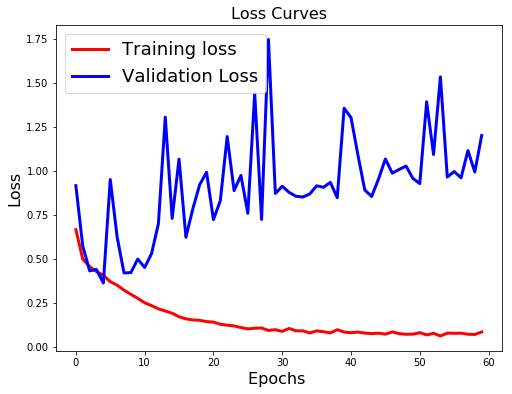

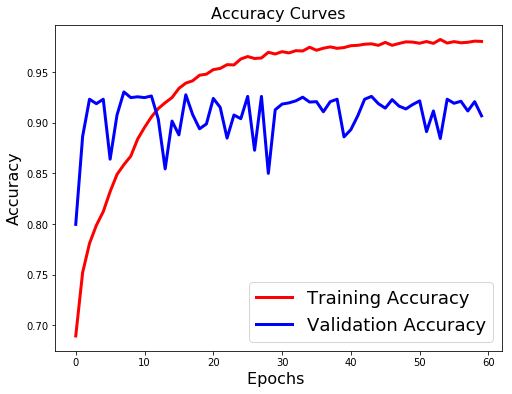

In [10]:
import matplotlib.pyplot as plt

print (history)
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
# import numpy as np

# csv_array= np.array([(1, 1.2),(2, 2.3),(3, 3.4)])
# np.savetxt("array.csv", csv_array, fmt='%d,%f',delimiter=',', header="id,label", comments="")